## Data Loading

In [2197]:
import xgboost as xgb
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# for pretty printing table
pandas_table = pd.option_context('display.max_rows', None, 'display.max_columns', None)
# increased font size for thesis plots
plt.rcParams.update({'font.size': 15})
# set a good figure size for the paper
figsize = (13,7)
set_figsize = lambda: plt.figure(figsize=(13,7))
savefig = lambda x: plt.savefig(os.path.join('figures', x), bbox_inches = "tight")

In [3]:
df = pd.read_csv(os.path.join('../mimic/data_processed', 'mimic_dataset_incomplete.csv'))

In [4]:
def df_split(df, ratio=0.2):
    '''
    Given dataframe, split 20% of patients into a separate test dataframe.
    Return df_train, df_test
    '''
    num_hadms = len(df['HADM_ID'].unique())
    split = int(ratio * num_hadms)
    hadms = df['HADM_ID'].unique()[:split]
    
    return df[~df.HADM_ID.isin(hadms)], df[df.HADM_ID.isin(hadms)]

df_train, df_test = df_split(df)

In [5]:
X_cols = [
    "Creatinine", "HCO3", "HR", "Haemoglobin", "Platelet_count",
    "Potassium", "RR", "Sodium", "AGE", "GENDER",
    'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma', #comorbidities
    'Weight_kg', 'SaO2'
]

In [6]:
df_test

,Creatinine,HCO3,HR,Haemoglobin,Platelet_count,Potassium,RR,Sodium,Weight_kg,SaO2,...,CHARTDATE,DAYS_TO_DISCH,AGE,GENDER,Day,DEATH,Chronic Kidney Disease,Obesity,Heart disease,Asthma
0,1.1,26.0,92.0,10.4,175.0,4.5,20.0,137.0,49.7,96.0,...,2188-05-25,6,56,1,1,0,0.0,0.0,0.0,0.0
1,1.2,23.0,89.0,10.2,175.0,4.8,12.0,134.0,49.7,97.0,...,2188-05-26,6,56,1,2,0,0.0,0.0,0.0,0.0
2,1.2,23.0,82.0,9.7,165.0,4.0,14.0,130.0,49.7,100.0,...,2188-05-27,6,56,1,3,0,0.0,0.0,0.0,0.0
3,1.1,24.0,74.0,10.3,166.0,4.0,11.0,136.0,49.7,100.0,...,2188-05-28,6,56,1,4,0,0.0,0.0,0.0,0.0
4,1.1,23.0,93.0,10.4,147.0,4.1,21.0,136.0,49.7,100.0,...,2188-05-29,6,56,1,5,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782,5.8,24.0,89.0,11.3,108.0,4.6,29.0,138.0,100.0,98.0,...,2160-05-08,6,62,1,2,1,1.0,0.0,0.0,0.0
2783,7.1,27.0,84.0,11.2,113.0,3.3,24.0,142.0,100.0,99.0,...,2160-05-09,6,62,1,3,1,1.0,0.0,0.0,0.0
2784,7.4,21.0,89.0,10.6,130.0,3.3,32.0,142.0,100.0,98.0,...,2160-05-10,6,62,1,4,1,1.0,0.0,0.0,0.0
2785,4.0,21.0,83.0,10.4,153.0,4.1,14.0,136.0,100.0,96.0,...,2160-05-11,6,62,1,5,1,1.0,0.0,0.0,0.0


In [4927]:
def create_tensors(df, num_days=99, admission=True):
    '''
    Split dataframe into X and Y tensors.

    Return X, Y
    '''
    hadms = df['HADM_ID'].unique()
    
    lst = []
    lst_y = []
    
    for hadm in hadms:
        point = df[df.HADM_ID == hadm][X_cols]
        
        # only use data points at least num_days long
        if len(point) >= num_days:
            # look at days from admission
            if admission:
                point = point[:num_days]
            else:
                point = point[::-1][:num_days][::-1] # days from discharge in reverse
        else:
            continue
            
        lst.append(point.values)
        lst_y.append(df[df.HADM_ID == hadm]['DEATH'].iloc[0])
    
    return lst, np.array(lst), np.array(lst_y)

## Hyperparameter search

In [223]:
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.05, n_estimators = 1000),
                        param_grid = parameters, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [30]:
gsearch1.fit(X_train, Y_train)

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': range(1, 20, 2),
                         'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
  

In [33]:
gsearch1.best_params_

{'alpha': 9, 'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 1.0}

In [89]:
gsearch1.best_score_

NameError: name 'gsearch1' is not defined

## Create and train model

In [5602]:
# store results for all lengths
num_days = 1
stored_results = {}
admission = False

In [6262]:
lst_train, X_train, Y_train = create_tensors(df_train, num_days=num_days, admission=admission)
lst_test, X_test, Y_test = create_tensors(df_test, num_days=num_days, admission=admission)

In [6263]:
X_train.shape

(8, 48, 16)

In [6264]:
# flatten data down (both days into one row)
X_train = X_train.reshape(-1, num_days * len(X_cols))
X_test = X_test.reshape(-1, num_days * len(X_cols))

In [6265]:
X_train.shape

(8, 768)

In [6266]:
parameters = {
    'max_depth' : range(3,10),
    'alpha' : range(1,20,2),
    'subsample' : [x / 10 for x in range(1, 11)],
    'colsample_bytree' : [x / 10 for x in range(1, 11)],
}

In [6267]:
xg = xgb.XGBClassifier(learning_rate=0.05, n_estimators=1000, alpha=15, colsample_bytree=0.4,
                       max_depth=5, subsample=1,
                       scale_pos_weight=np.sqrt(sum(1 - np.append(Y_train, Y_test)) / sum(np.append(Y_train, Y_test))))

In [6268]:
xg.fit(X_train, Y_train)

XGBClassifier(alpha=15, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=15,
              reg_lambda=1, scale_pos_weight=1.2909944487358056, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [6269]:
# train accuracy
train_preds = xg.predict(X_train)
print(classification_report(Y_train, np.rint(train_preds).astype(int)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



In [6270]:
# test accuracy
test_preds = xg.predict(X_test)
print(classification_report(Y_test, np.rint(test_preds).astype(int)))

ValueError: max() arg is an empty sequence

In [ ]:
1 - sum(Y_test) / len(Y_test)

In [ ]:
np.rint(test_preds).astype(int)[np.argsort(Y_test)[::-1]]

In [ ]:
stored_results[num_days] = {
    'test acc': accuracy_score(Y_test, np.rint(test_preds).astype(int)),
    'train acc': accuracy_score(Y_train, np.rint(train_preds).astype(int)),
    'discharged': 1 - sum(Y_test) / len(Y_test),
    'death': sum(Y_test) / len(Y_test),
    'length_data': np.append(Y_train, Y_test).shape[0],
    'f1 test': f1_score(Y_test, np.rint(test_preds).astype(int)),
    'f1 train': f1_score(Y_train, np.rint(train_preds).astype(int)),
}

In [ ]:
num_days += 1

In [ ]:
%%javascript
// Retrain model and increase num_days
Jupyter.notebook.execute_cells(Array(14).fill(15).map((x, y) => x + y))

<IPython.core.display.Javascript object>

In [6271]:
stored_results

{1: {'test acc': 0.8432055749128919,
  'train acc': 0.872822299651568,
  'discharged': 0.7090592334494774,
  'death': 0.29094076655052264,
  'length_data': 2870,
  'f1 test': 0.7352941176470588,
  'f1 train': 0.7980636237897648},
 2: {'test acc': 0.8064516129032258,
  'train acc': 0.8724179829890644,
  'discharged': 0.6612903225806452,
  'death': 0.3387096774193548,
  'length_data': 2018,
  'f1 test': 0.7024793388429752,
  'f1 train': 0.8217317487266553},
 3: {'test acc': 0.8041666666666667,
  'train acc': 0.8608852755194218,
  'discharged': 0.5666666666666667,
  'death': 0.43333333333333335,
  'length_data': 1347,
  'f1 test': 0.758974358974359,
  'f1 train': 0.8368644067796609},
 4: {'test acc': 0.796875,
  'train acc': 0.8464243845252052,
  'discharged': 0.5260416666666667,
  'death': 0.4739583333333333,
  'length_data': 1045,
  'f1 test': 0.7745664739884394,
  'f1 train': 0.8372670807453416},
 5: {'test acc': 0.7839506172839507,
  'train acc': 0.8486171761280932,
  'discharged': 0.

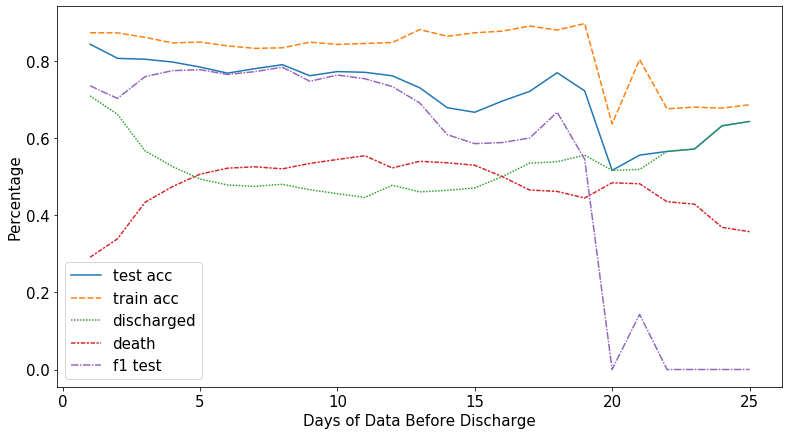

In [6272]:
set_figsize()
sns.lineplot(data=pd.DataFrame(stored_results).drop(['length_data', 'f1 train']).T[:25])
plt.ylabel('Percentage')
plt.xlabel(f'Days of {"Admission Data" if admission else "Data Before Discharge"}')
title = f'Random Forest {"Admission" if admission else "Discharge"}'
savefig(title)

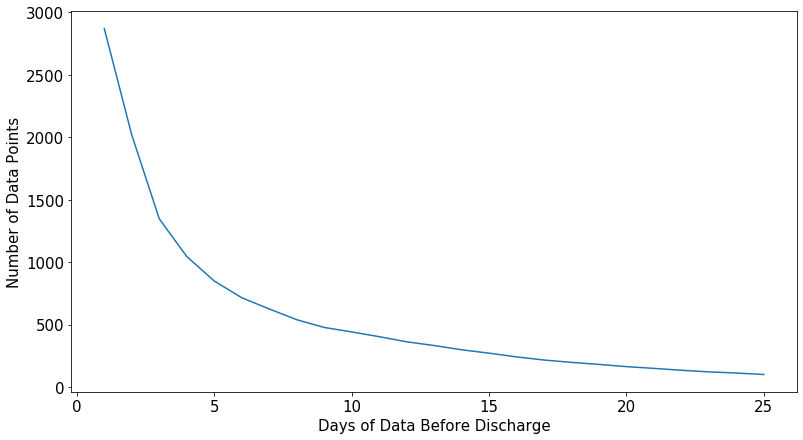

In [6274]:
set_figsize()
sns.lineplot(data=pd.DataFrame(stored_results).T['length_data'][:25])
plt.ylabel('Number of Data Points')
plt.xlabel(f'Days of {"Admission Data" if admission else "Data Before Discharge"}')
title = f'Random Forest {"Admission" if admission else "Discharge"} Data'
savefig(title)

# SHAP

In [37]:
import shap as shap

In [38]:
# https://github.com/slundberg/shap/issues/1215
model_bytearray = xg.get_booster().save_raw()[4:]
def myfun(self=None):
    return model_bytearray

xg.get_booster().save_raw = myfun

In [39]:
explainer = shap.TreeExplainer(xg)

In [40]:
xgb_shap = explainer.shap_values(X_test)

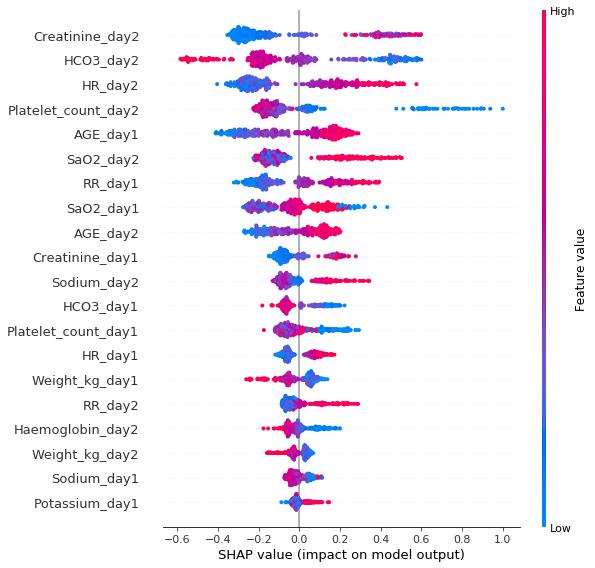

In [190]:
feature_names = [s + '_day' + str(x+1) for x in range(num_days) for s in X_cols]
shap.summary_plot(
    xgb_shap, X_test, feature_names=feature_names, plot_type="dot",
    auto_size_plot=False
)

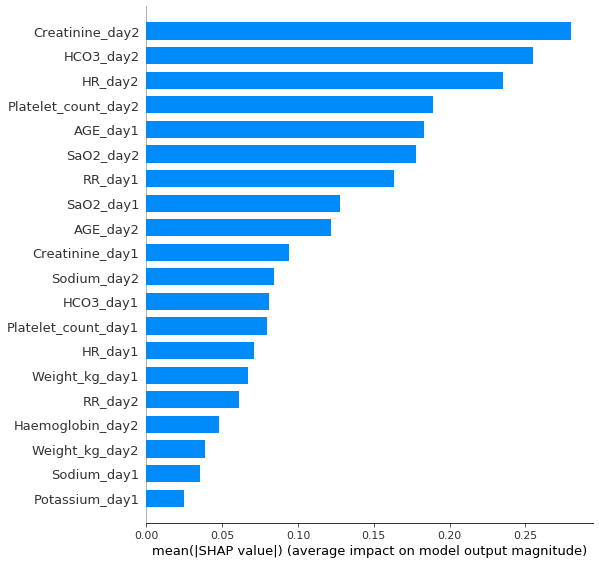

In [42]:
shap.summary_plot(
    xgb_shap, X_test, feature_names=feature_names, plot_type="bar",
    auto_size_plot=False, show=False
)

In [43]:
xgb_shap_interaction = explainer.shap_interaction_values(X_test)

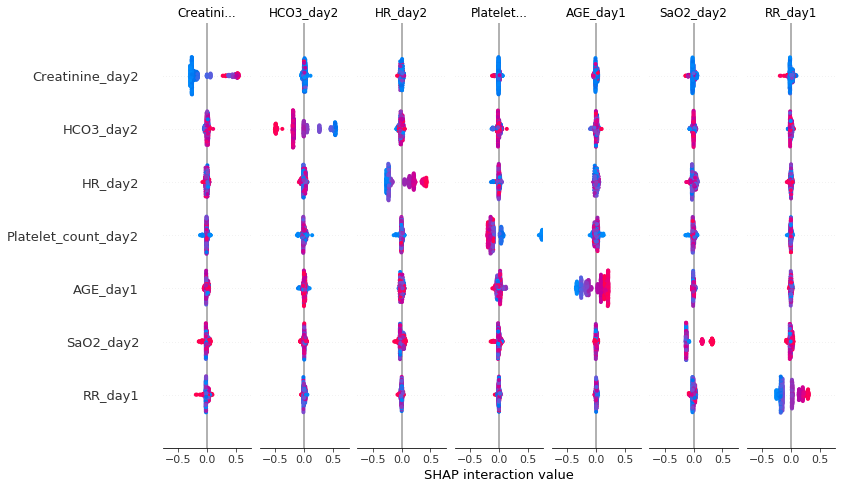

In [194]:
shap.summary_plot(xgb_shap_interaction, X_test, feature_names=np.array(feature_names))

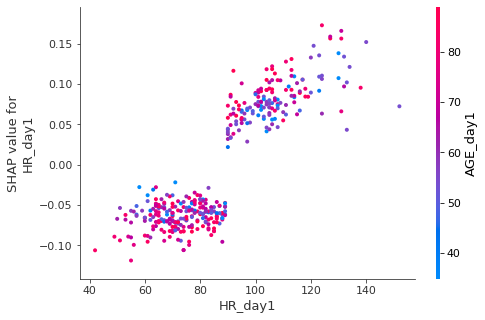

In [202]:
shap.dependence_plot("HR_day1", xgb_shap, X_test, feature_names=np.array(feature_names), interaction_index="AGE_day1")

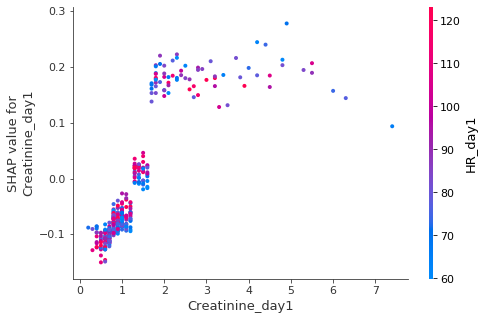

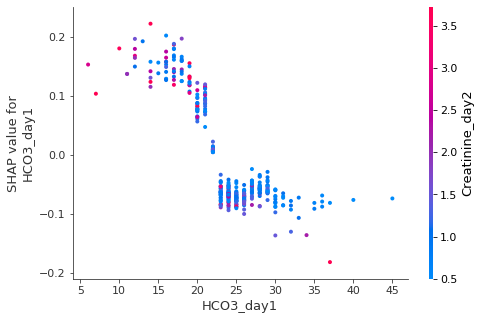

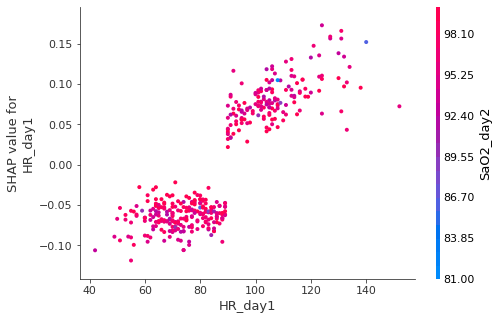

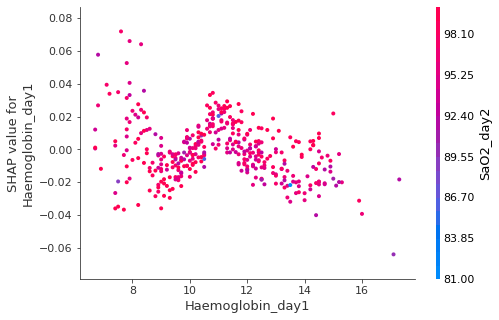

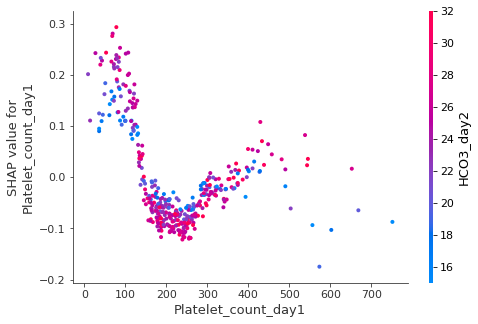

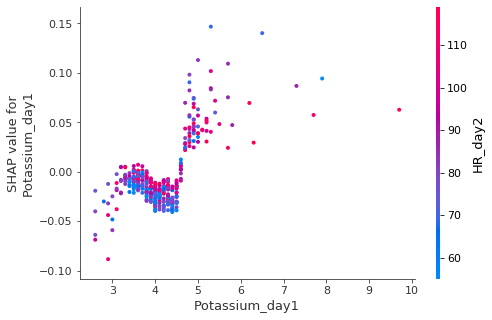

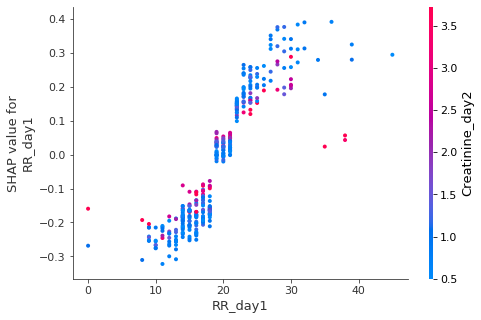

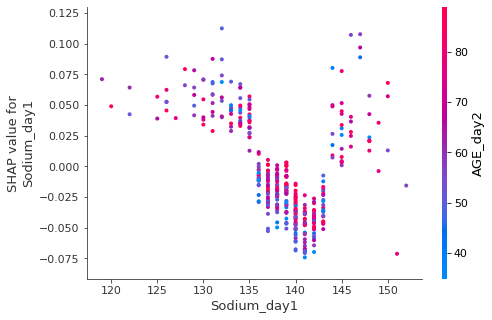

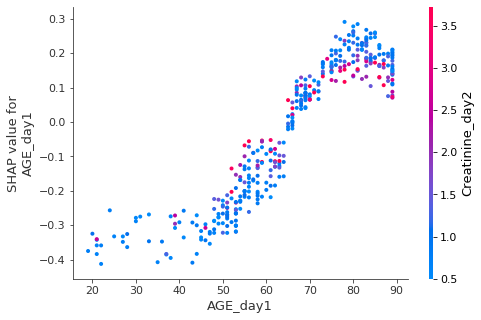

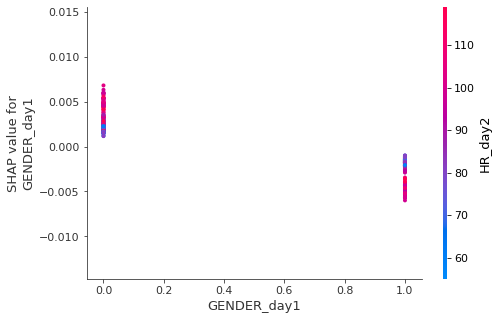

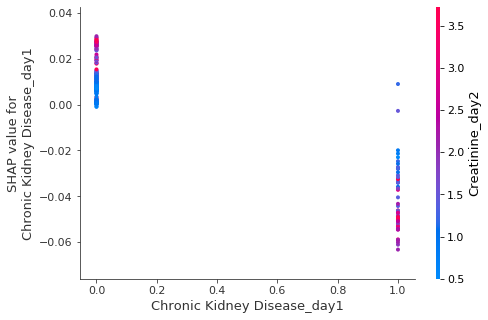

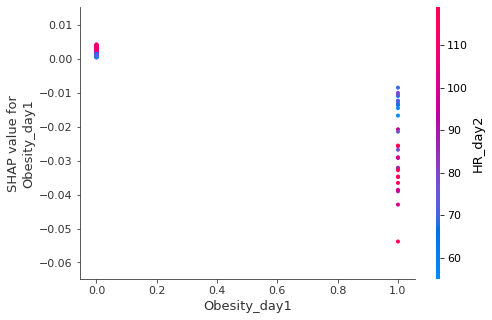

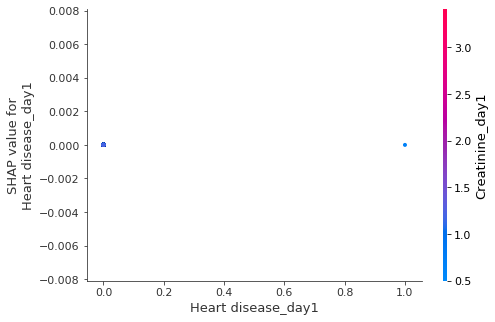

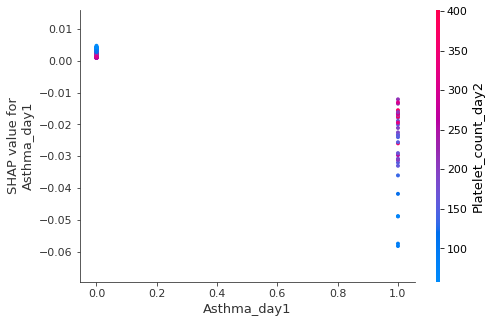

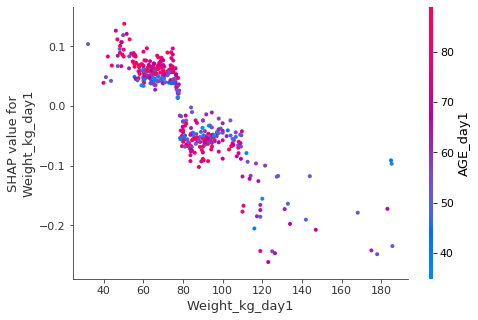

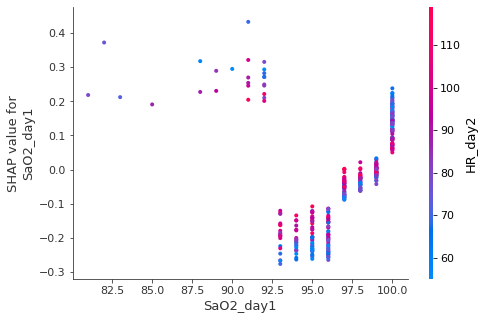

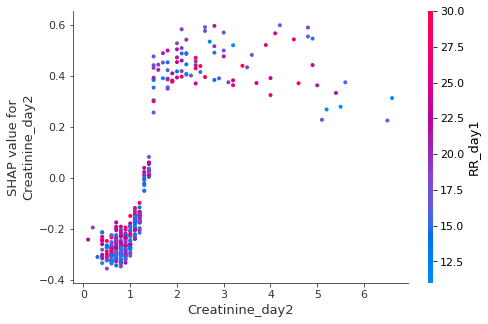

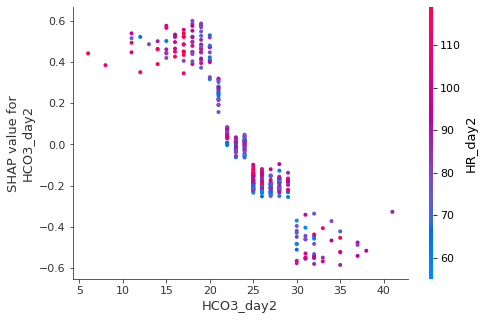

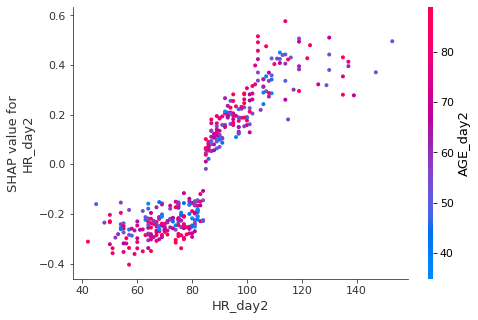

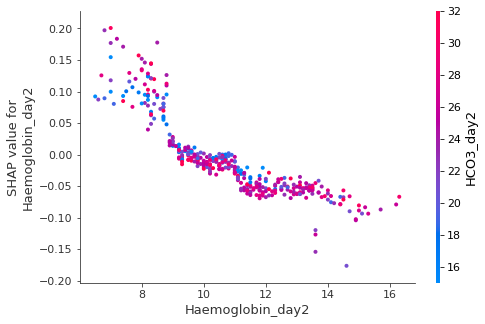

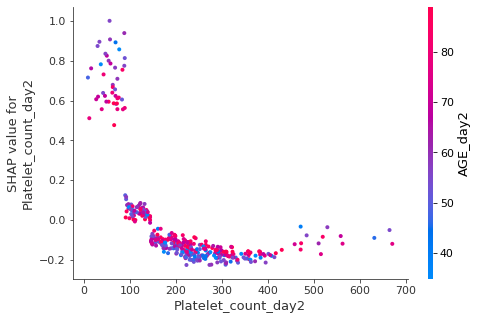

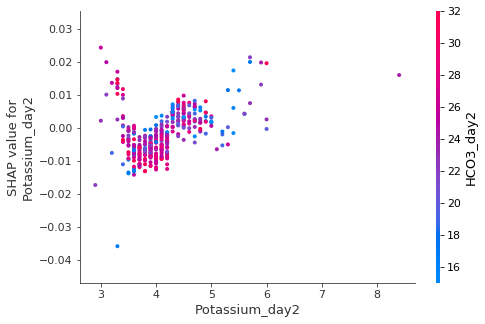

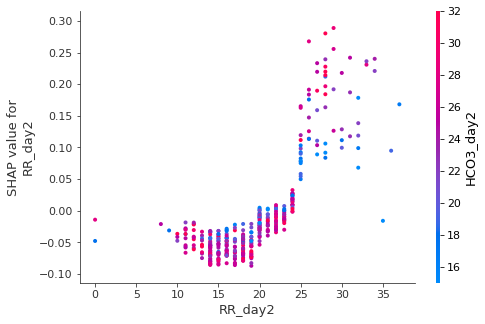

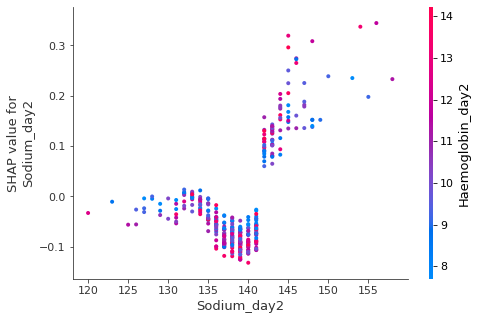

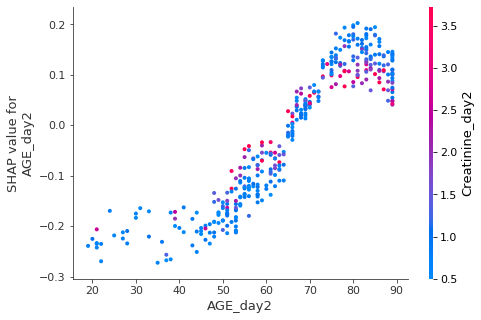

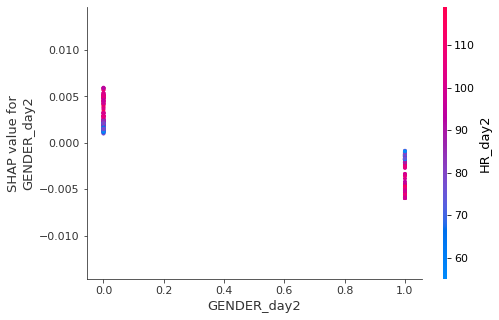

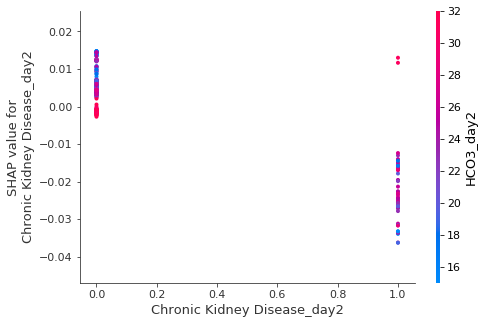

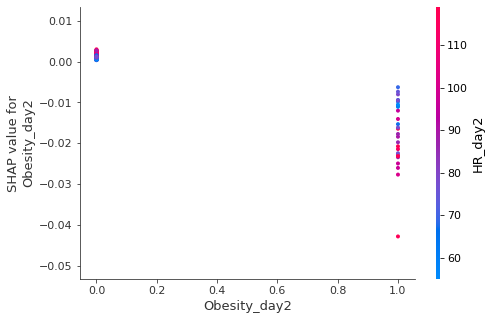

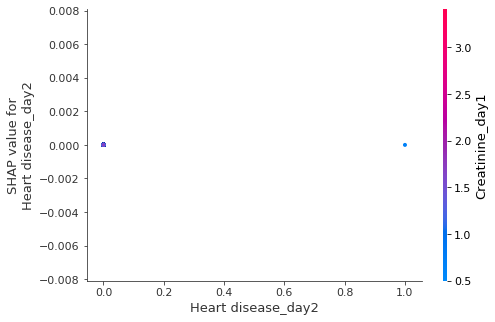

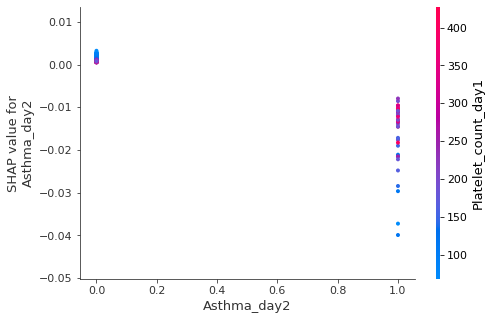

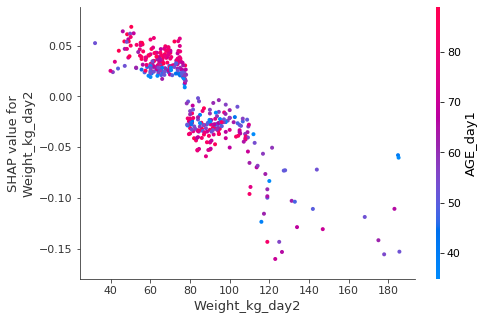

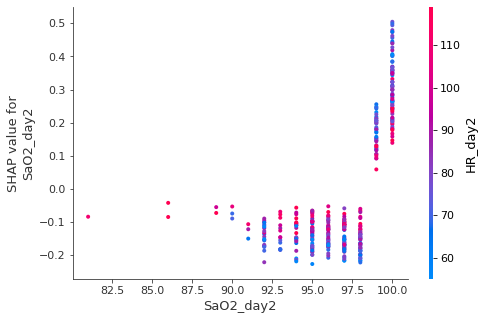

In [214]:
for feature in feature_names:
    shap.dependence_plot(feature, xgb_shap, X_test, feature_names=np.array(feature_names))    

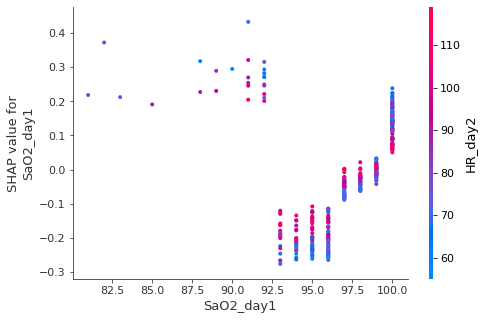

In [212]:
# note how a high HR is more concerning if you have a low SaO2
shap.dependence_plot("SaO2_day1", xgb_shap, X_test, feature_names=np.array(feature_names))

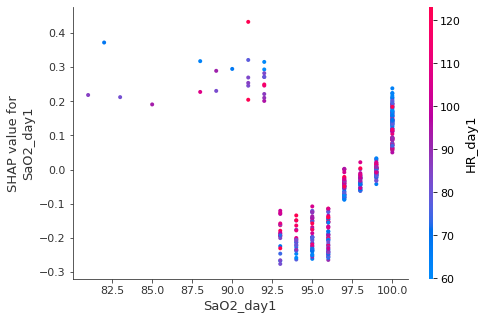

In [210]:
# note how a high HR is more concerning if you have a low SaO2
shap.dependence_plot("SaO2_day1", xgb_shap, X_test, feature_names=np.array(feature_names), interaction_index="HR_day1")

In [215]:
X_cols

['Creatinine',
 'HCO3',
 'HR',
 'Haemoglobin',
 'Platelet_count',
 'Potassium',
 'RR',
 'Sodium',
 'AGE',
 'GENDER',
 'Chronic Kidney Disease',
 'Obesity',
 'Heart disease',
 'Asthma',
 'Weight_kg',
 'SaO2']

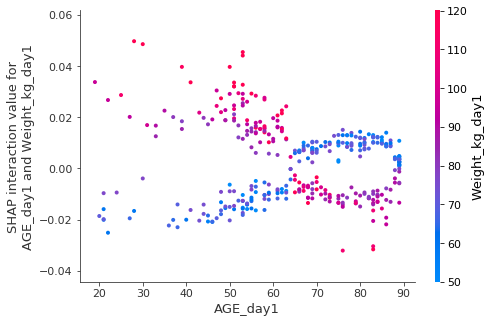

In [218]:
shap.dependence_plot(("AGE_day1", "Weight_kg_day1"), xgb_shap_interaction, X_test, feature_names=np.array(feature_names))

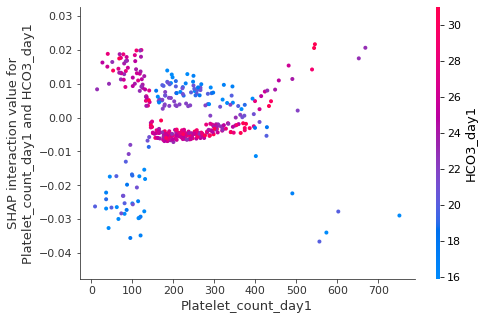

In [217]:
shap.dependence_plot(("Platelet_count_day1", "HCO3_day1"), xgb_shap_interaction, X_test, feature_names=np.array(feature_names))

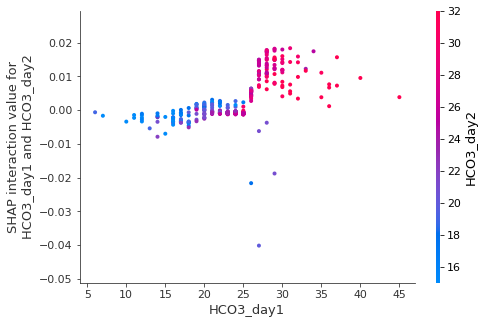

In [44]:
shap.dependence_plot(("HCO3_day1", "HCO3_day2"), xgb_shap_interaction, X_test, feature_names=np.array(feature_names))

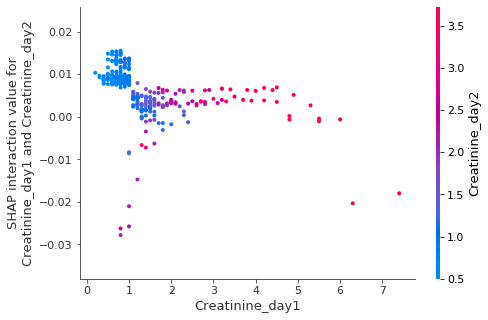

In [47]:
shap.dependence_plot(("Creatinine_day1", "Creatinine_day2"), xgb_shap_interaction, X_test, feature_names=np.array(feature_names))

Text(0, 0.5, 'HCO3 day 2')

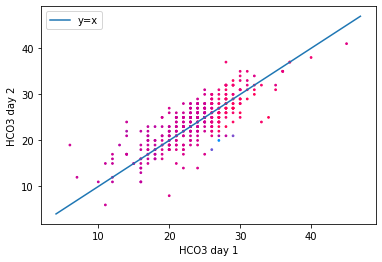

In [170]:
feature = 'HCO3'

ax = plt.scatter(X_test[:, X_cols.index(feature)],
                X_test[:,len(X_cols) + X_cols.index(feature)], s=3,
                c=xgb_shap_interaction[:, X_cols.index(feature), len(X_cols) + X_cols.index(feature)],
                cmap=colors.red_blue)

fig = sns.lineplot(x=ax.axes.get_xlim(), y=ax.axes.get_xlim(), label='y=x')

plt.xlabel(f"{feature} day 1")
plt.ylabel(f"{feature} day 2")

Text(0, 0.5, 'Creatinine day 2')

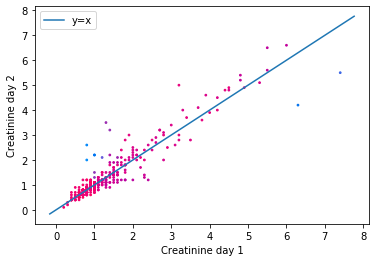

In [192]:
feature = 'Creatinine'

ax = plt.scatter(X_test[:, X_cols.index(feature)],
                X_test[:,len(X_cols) + X_cols.index(feature)], s=3,
                c=xgb_shap_interaction[:, X_cols.index(feature), len(X_cols) + X_cols.index(feature)],
                cmap=colors.red_blue)

fig = sns.lineplot(x=ax.axes.get_xlim(), y=ax.axes.get_xlim(), label='y=x')

plt.xlabel(f"{feature} day 1")
plt.ylabel(f"{feature} day 2")

Text(0, 0.5, 'Creatinine day 2')

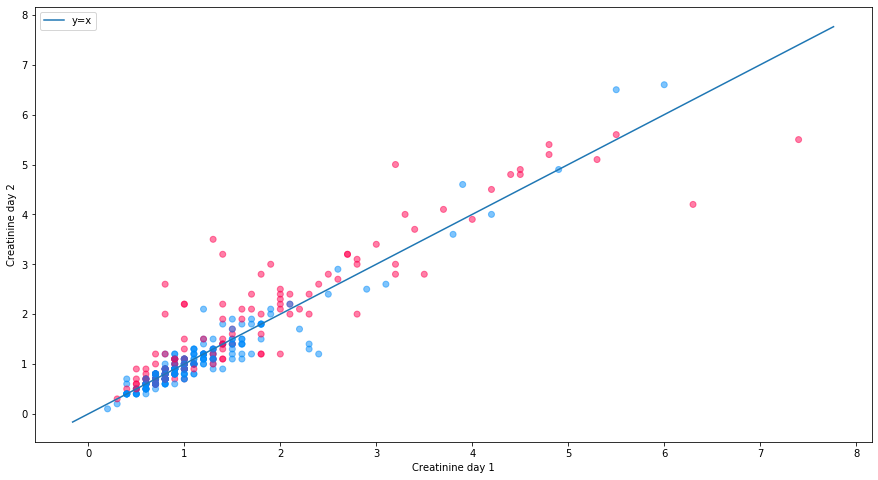

In [167]:
feature = 'Creatinine'
ind = X_cols.index(feature)

plt.figure(figsize=(15,8))

ax = plt.scatter(X_test[:, ind], X_test[:,len(X_cols) + ind],
                c=Y_test, alpha=0.5, cmap=colors.red_blue)

fig = sns.lineplot(x=ax.axes.get_xlim(), y=ax.axes.get_xlim(), label='y=x')
plt.xlabel(f"{feature} day 1")
plt.ylabel(f"{feature} day 2")

In [168]:
# death rate of increasing feature between days
arr = Y_test[X_test[:, ind] > X_test[:,len(X_cols)+ind]]

sum(arr) / len(arr), len(arr)

(0.28, 150)

In [169]:
# death rate of decreasing feature between days 
arr = Y_test[X_test[:, ind] < X_test[:,len(X_cols)+ind]]

sum(arr) / len(arr), len(arr)

(0.5441176470588235, 136)